# NBA Hackathon Business Question
### By: Ford Higgins
This question required fewer self-written functions thanks to pre-existing packages, but still allowed for creativity with the model-building decisions. I utilized a basic linear regression, a random forest regressor, and a LightGBM regressor for my models and evaluated each of them with MAPE. The random forest was also evaluated with the help of Terence Parr's (one of my professors) `rfpimp` package. I mostly tried features relating to the date of the game and team/player quality. 

In [1]:
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import rfpimp

from datetime import datetime
from pandas.tseries.holiday import USFederalHolidayCalendar
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

In [2]:
#https://stats.stackexchange.com/questions/58391/mean-absolute-percentage-error-mape-in-scikit-learn/62511#62511
def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [3]:
game_data = pd.read_csv('game_data.csv')
player_data = pd.read_csv('player_data.csv')
train = pd.read_csv('training_set.csv').rename(columns={'Rounded Viewers': 'Rounded_Viewers'}) # this was annoying me
test = pd.read_csv('test_set.csv')

In [4]:
train.head()

,Season,Game_ID,Game_Date,Away_Team,Home_Team,Country,Rounded_Viewers
0,2016-17,21600001,10/25/2016,NYK,CLE,C113,18
1,2016-17,21600001,10/25/2016,NYK,CLE,C193,1
2,2016-17,21600001,10/25/2016,NYK,CLE,C126,4
3,2016-17,21600001,10/25/2016,NYK,CLE,C163,11
4,2016-17,21600001,10/25/2016,NYK,CLE,C73,3


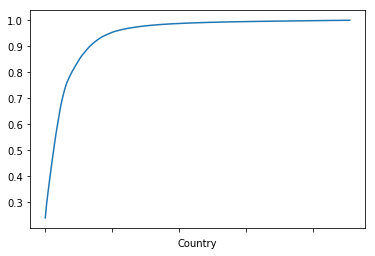

In [5]:
train_country_pcts = train.groupby('Country')['Rounded_Viewers'].mean().sort_values(ascending = False).cumsum()\
            /train.groupby('Country')['Rounded_Viewers'].mean().sum()

train_country_pcts.plot()

In [6]:
(train_country_pcts < 0.9).sum() # keep the top 34 countries

34

In [7]:
keep_countries = train_country_pcts[train_country_pcts < 0.9].index.tolist()

train_v2 = train[train.Country.isin(keep_countries)]
total_viewers_keep = train_v2.groupby('Game_ID').sum().reset_index()
#train_v2.groupby('Game_ID').sum().reset_index()
train_v2 = train_v2[['Season', 'Game_ID', 'Game_Date',
                     'Away_Team', 'Home_Team']].drop_duplicates(keep = 'first').reset_index(drop=True).merge(total_viewers_keep, 
                                                                                                             on = 'Game_ID')

In [8]:
cal = USFederalHolidayCalendar()
nba_holidays = cal.holidays(start='2016-10-01', end='2018-05-01') # add any?

# adding in these dates makes it worse
# other_dates = ['2016-10-25', '2016-10-26', '2017-10-17', '2017-10-18',
#                '2017-04-11', '2017-04-12', '2018-04-10', '2018-04-11',
#               '2016-12-25']

# for x in pd.to_datetime(other_dates):
#     nba_holidays = nba_holidays.insert(-1, x)

# replacing observed Christmas with actual Christmas
nba_holidays = nba_holidays.insert(-1, pd.to_datetime('2016-12-25'))
nba_holidays = nba_holidays.drop(pd.to_datetime(['2016-12-26']))

In [9]:
train_v2.Game_Date = pd.to_datetime(train_v2.Game_Date)
train_v2['dayofweek'] = train_v2.Game_Date.dt.dayofweek
train_v2['is_weekend'] = train_v2.dayofweek.apply(lambda x: 1 if x >= 4 else 0)
train_v2['month'] = train_v2.Game_Date.dt.month
train_v2['day'] = train_v2.Game_Date.dt.day
train_v2['is_holiday'] = train_v2.Game_Date.isin(nba_holidays)
train_v2.Season = train_v2.Season.apply(lambda x: 0 if x == '2016-17' else 1)
# how to get opening day/week? add to holidays?

In [10]:
test.head()

,Season,Game_ID,Game_Date,Away_Team,Home_Team,Total_Viewers
0,2016-17,21600010,10/26/2016,DEN,NOP,NaN
1,2016-17,21600023,10/28/2016,HOU,DAL,NaN
2,2016-17,21600027,10/29/2016,BOS,CHA,NaN
3,2016-17,21600026,10/29/2016,ATL,PHI,NaN
4,2016-17,21600048,11/1/2016,LAL,IND,NaN


In [11]:
test.shape

(460, 6)

**Features to consider:**
- create a validation set from the training set
- countries: aggregating across countries. are some of them responsible for most of the viewers? only take viewers from the biggest ones?
    - don't have the same level of detail in the test set, so might not be useful
- game_date: is_weekend (Fri, Sat, & Sun), month, day in month, is_holiday (specifically Christmas and MLK), 
    - use circular encoding for some of these?
    - before/after ASG and trade deadline?
    - end of season
    - Thursdays are big nationally televised games
- circular encoding for home and away teams? or label encoding?
    - treat home and away differently
- target encoding for some variables?
- how to handle season? ignore it? one-hot it?
- win percentage
- ties/lead_changes 
    - *not in test set*
- L2M score differential 
    - *not in test set*
- number of all_stars active
- triple_double? a lot of threes? 30+ points? 40+ points? 50+ points? 
    - *not in test set*
- end of season and teams close record-wise
- number of timeouts used 
    - *not in test set*
- comebacks? 
    - *not in test set*
- number of games that day? preceding day?
- arbitrary superstars? top 5 jersey sellers or something? Steph, LBJ, KD, Russ, Giannis? maybe for later


Can more or less ignore anything that was recorded as a result of the game being played since this is predictive and not explanatory, and we would need those features in the test set as well for prediction, but they aren't going to be there. 

In [12]:
game_data.head()

,Season,Game_ID,Game_Date,Team,Location,Wins_Entering_Gm,Losses_Entering_Gm,Team_Minutes,Final_Score,Lead_Changes,Ties,Largest_Lead,Full_Timeouts,Short_Timeouts,Qtr_4_Score,L2M_Score
0,2016-17,21600001,10/25/2016,CLE,H,0,0,240.0,117.0,1.0,3.0,32.0,4.0,1.0,82.0,113.0
1,2016-17,21600001,10/25/2016,NYK,A,0,0,240.0,88.0,0.0,1.0,4.0,4.0,2.0,64.0,84.0
2,2016-17,21600002,10/25/2016,POR,H,0,0,240.0,113.0,6.0,6.0,13.0,5.0,0.0,77.0,104.0
3,2016-17,21600002,10/25/2016,UTA,A,0,0,240.0,104.0,5.0,1.0,8.0,5.0,2.0,83.0,102.0
4,2016-17,21600003,10/25/2016,GSW,H,0,0,240.0,100.0,1.0,2.0,4.0,3.0,1.0,77.0,100.0


In [13]:
game_data['n_games'] = game_data.apply(lambda x: x.Wins_Entering_Gm + x.Losses_Entering_Gm, axis = 1)
game_data['win_pct'] = game_data.apply(lambda x: float(x.Wins_Entering_Gm)/(x.n_games) 
                                       if (x.n_games) > 0 else 0.5, axis = 1)

# game_data['is_ot'] = game_data.Team_Minutes.apply(lambda x: 1 if x > 240 else 0)
# game_data['n_timeouts'] = game_data.apply(lambda x: x.Full_Timeouts + x.Short_Timeouts, axis = 1)
# game_data['n_ties_changes'] = game_data.apply(lambda x: x.Lead_Changes + x.Ties, axis = 1)

game_keep = ['Game_ID', 'Team', 'Location', 'Wins_Entering_Gm', 'Losses_Entering_Gm', 'n_games', 'win_pct']
game_v2 = game_data[game_keep]

game_v2_flat = game_v2.loc[game_v2.Location == 'H'].merge(game_v2.loc[game_v2.Location == 'A'],
                                                          on = 'Game_ID', suffixes = ['_H', '_A'])

game_v2_flat['win_diff'] = game_v2_flat.apply(lambda x: x.Wins_Entering_Gm_H - x.Wins_Entering_Gm_A, axis = 1)
game_v2_flat['loss_diff'] = game_v2_flat.apply(lambda x: x.Losses_Entering_Gm_H - x.Losses_Entering_Gm_A, axis = 1)
game_v2_flat['win_pct_diff'] = game_v2_flat.apply(lambda x: x.win_pct_H - x.win_pct_A, axis = 1)

# change ASG to binary variable
player_data['is_allstar'] = player_data.ASG_Team.apply(lambda x: 1 if x in ['East ASG', 'West ASG'] else 0)
player_data['active_allstars'] = player_data.apply(lambda x: x.is_allstar if x.Active_Status == 'Active' else 0, axis = 1)

player_keep = ['Game_ID', 'Team', 'Person_ID', 'Name', 'is_allstar', 'Active_Status', 'active_allstars']
player_v2 = player_data[player_keep]

n_active_allstars = player_v2.groupby('Game_ID').active_allstars.sum() # should I split this into home and away?
n_active_allstars = pd.DataFrame(n_active_allstars).reset_index()

train_v3 = train_v2.merge(game_v2_flat, left_on = ['Game_ID', 'Away_Team', 'Home_Team'],
               right_on = ['Game_ID', 'Team_A', 'Team_H']).merge(n_active_allstars, on = 'Game_ID')
train_v3.drop(['Team_H', 'Team_A', 'Game_ID', 'Game_Date', 'Location_H', 'Location_A'], inplace=True, axis=1)

In [14]:
train_v3.head()

,Season,Away_Team,Home_Team,Rounded_Viewers,dayofweek,is_weekend,month,day,is_holiday,Wins_Entering_Gm_H,...,n_games_H,win_pct_H,Wins_Entering_Gm_A,Losses_Entering_Gm_A,n_games_A,win_pct_A,win_diff,loss_diff,win_pct_diff,active_allstars
0,0,NYK,CLE,51251,1,0,10,25,False,0,...,0,0.5,0,0,0,0.5,0,0,0.0,4
1,0,SAS,GSW,53525,1,0,10,25,False,0,...,0,0.5,0,0,0,0.5,0,0,0.0,5
2,0,UTA,POR,36887,1,0,10,25,False,0,...,0,0.5,0,0,0,0.5,0,0,0.0,0
3,0,BKN,BOS,21864,2,0,10,26,False,0,...,0,0.5,0,0,0,0.5,0,0,0.0,1
4,0,CHA,MIL,11085,2,0,10,26,False,0,...,0,0.5,0,0,0,0.5,0,0,0.0,2


In [15]:
le_home = LabelEncoder()
le_away = LabelEncoder()
train_v3.Home_Team = le_home.fit_transform(train_v3.Home_Team)
train_v3.Away_Team = le_away.fit_transform(train_v3.Away_Team)

In [16]:
train_v3.head(3).transpose()
# can drop Team_H, Team_A, Game_ID, and Game_Date
# label encode home and away
# what to do with Location_H and Location_A? drop?
# apply same transformations to test set -- might be tough making it because it's all NaN's
# no target encoding so don't need to worry about leaking into validation set
# create validation set

,0,1,2
Season,0,0,0
Away_Team,19,26,28
Home_Team,5,9,24
Rounded_Viewers,51251,53525,36887
dayofweek,1,1,1
is_weekend,0,0,0
month,10,10,10
day,25,25,25
is_holiday,False,False,False
Wins_Entering_Gm_H,0,0,0


In [17]:
X = train_v3.drop('Rounded_Viewers', axis = 1)
y = train_v3.Rounded_Viewers

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size = 500, random_state = 11)

**Feature Engineering on Test Set**

In [18]:
test.Game_Date = pd.to_datetime(test.Game_Date)
test['dayofweek'] = test.Game_Date.dt.dayofweek
test['is_weekend'] = test.dayofweek.apply(lambda x: 1 if x >= 4 else 0)
test['month'] = test.Game_Date.dt.month
test['day'] = test.Game_Date.dt.day
test['is_holiday'] = test.Game_Date.isin(nba_holidays)
test.Season = test.Season.apply(lambda x: 0 if x == '2016-17' else 1)

test_v2 = test.merge(game_v2_flat, left_on = ['Game_ID', 'Away_Team', 'Home_Team'],
               right_on = ['Game_ID', 'Team_A', 'Team_H']).merge(n_active_allstars, on = 'Game_ID')
test_v2 = test_v2[test_v2.isnull().any(axis = 1)].reset_index(drop = True)
test_v2.drop(['Team_H', 'Team_A', 'Game_ID', 'Game_Date', 'Location_H', 'Location_A'], inplace=True, axis=1)

test_v2.Away_Team = le_away.transform(test_v2.Away_Team)
test_v2.Home_Team = le_home.transform(test_v2.Home_Team)

In [19]:
test_v2.head(3).transpose()

,0,1,2
Season,0,0,0
Away_Team,7,10,2
Home_Team,18,6,3
Total_Viewers,NaN,NaN,NaN
dayofweek,2,4,5
is_weekend,0,1,1
month,10,10,10
day,26,28,29
is_holiday,False,False,False
Wins_Entering_Gm_H,0,0,2


In [20]:
train_v3.shape, test_v2.shape

((2000, 21), (460, 21))

In [21]:
X_test = test_v2.drop('Total_Viewers', axis = 1)
y_test = test_v2.Total_Viewers

### Model Fitting Time!

In [22]:
lr = LinearRegression(normalize = True)
rfr = RandomForestRegressor(n_estimators=50, n_jobs=-1, random_state=42) # keep it fairly basic for now

In [23]:
lr.fit(X_train, y_train)
lr_pred_val = lr.predict(X_valid)
lr_pred_test = lr.predict(X_test)
mean_absolute_percentage_error(y_valid, lr_pred_val)

49.670508863338995

In [24]:
rfr.fit(X_train, y_train)
rfr_pred_val = rfr.predict(X_valid)
mean_absolute_percentage_error(y_valid, rfr_pred_val)

40.25392280209501

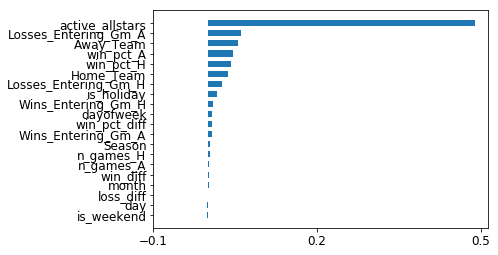

In [25]:
imp = rfpimp.importances(rfr, X_valid, y_valid)
rfpimp.plot_importances(imp)

In [27]:
rfr_keep = imp[imp.Importance > 0.02].index
rfr_keep

Index(['Losses_Entering_Gm_H', 'Home_Team', 'win_pct_H', 'win_pct_A',
       'Away_Team', 'Losses_Entering_Gm_A', 'active_allstars'],
      dtype='object', name='Feature')

In [28]:
X_tr_rfr = X_train[rfr_keep]
X_val_rfr = X_valid[rfr_keep]

In [29]:
rfr.fit(X_tr_rfr, y_train)
rfr_pred_val2 = rfr.predict(X_val_rfr)
mean_absolute_percentage_error(y_valid, rfr_pred_val2)

38.910321478027484

#### Attempting LightGBM
Data may be too small and get overfit by a GBM

In [40]:
d_train_lgb = lgb.Dataset(X_train, y_train)
d_valid_lgb = lgb.Dataset(X_valid, y_valid)

In [84]:
lgbr = lgb.LGBMRegressor(n_jobs=-1, n_estimators=50, random_state = 42, colsample_bytree=0.5, max_depth = 5)

In [85]:
lgbr.fit(X_train, y_train)

LGBMRegressor(boosting_type='gbdt', class_weight=None, colsample_bytree=0.5,
       learning_rate=0.1, max_depth=5, min_child_samples=20,
       min_child_weight=0.001, min_split_gain=0.0, n_estimators=50,
       n_jobs=-1, num_leaves=31, objective=None, random_state=42,
       reg_alpha=0.0, reg_lambda=0.0, silent=True, subsample=1.0,
       subsample_for_bin=200000, subsample_freq=0)

In [86]:
lgbr_pred_val = lgbr.predict(X_valid)
mean_absolute_percentage_error(y_valid, lgbr_pred_val)

36.585574487303724

In [114]:
((lgbr.feature_importances_/lgbr.feature_importances_.sum()) > 0.05)

array([False,  True,  True,  True, False, False, False, False, False,
        True, False,  True, False,  True, False,  True, False, False,
       False,  True])

In [116]:
lgb_keep = ['Away_Team', 'Home_Team', 'dayofweek', 'Losses_Entering_Gm_H',
            'win_pct_H', 'Losses_Entering_Gm_A', 'win_pct_A', 'active_allstars']
lgbr.fit(X_train[lgb_keep], y_train)
lgbr_pred_val2 = lgbr.predict(X_valid[lgb_keep])
mean_absolute_percentage_error(y_valid, lgbr_pred_val2)

37.73504529636949

Keeping all of the columns adds information.

### Writing out the Test File

In [120]:
rfr_pred_test = rfr.predict(X_test[rfr_keep])
test_with_pred = test.drop(['dayofweek', 'is_weekend', 'month', 'day', 'is_holiday'], axis = 1).copy()
# change season back:
test_with_pred.Season = test_with_pred.Season.apply(lambda x: '2016-17' if x == 0 else '2017-18')
test_with_pred.Total_Viewers = rfr_pred_test

In [121]:
test_with_pred.head()

,Season,Game_ID,Game_Date,Away_Team,Home_Team,Total_Viewers
0,2016-17,21600010,2016-10-26,DEN,NOP,23441.18
1,2016-17,21600023,2016-10-28,HOU,DAL,16393.82
2,2016-17,21600027,2016-10-29,BOS,CHA,23443.06
3,2016-17,21600026,2016-10-29,ATL,PHI,21893.44
4,2016-17,21600048,2016-11-01,LAL,IND,16572.44


In [122]:
test_with_pred.to_csv('test_set_Higgins_Ford.csv')

<p>I opted to use the results from the Random Forest since they are less prone to overfitting than GBMs, and considering the size of the dataset, this could certainly be an issue. The final columns that were used in the model were `Losses_Entering_Gm_H`, `Home_Team`, `win_pct_H`, `win_pct_A`, `Away_Team`, `Losses_Entering_Gm_A`, and `active_allstars`, with `active_allstars` dominating the feature importances. This intuitively makes sense as people tune in to watch the best players play, though some of the other results are not as straightforward. It is curious that losses show up as important, but wins do not, and that each feature shows up as important for both the home and away teams. </p>

<p>Future iterations could include outside data, which I did not have the time to really research and incorporate into my model building. Trying different numbers of countries to include in the model, different encodings for both the teams and dates, and adding 'holidays' for games before and after the All Star Game and Trade Deadline could all be interesting features. Utilizing target encoding could also improve the predictiveness of the model. It would be interesting to know if the LightGBM model actually does overfit the test data, too. Other validation sets could be tried, too.</p>